# Libraries

In [2]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.utils import resample
from textblob import TextBlob
from collections import Counter
import re
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


AttributeError: partially initialized module 'nltk' has no attribute 'data' (most likely due to a circular import)

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

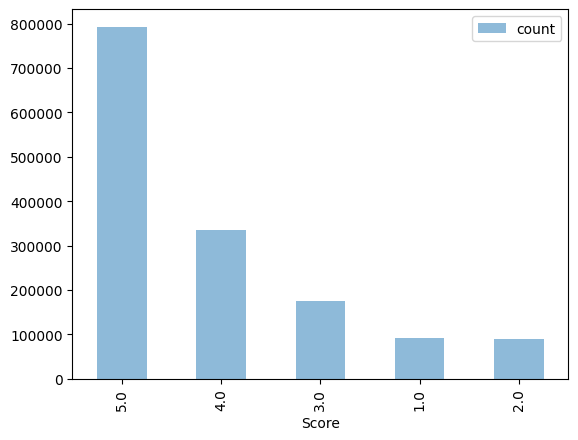


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")
# 2. Define the Downscaling Function
def downscale_classes(df, target_column):
    # Count the number of instances in each class
    class_counts = df[target_column].value_counts()
    
    # Find the minimum class count
    min_count = class_counts.min()
    
    # Create a new DataFrame to hold the downscaled data
    downscaled_df = pd.DataFrame()
    
    for class_label in class_counts.index:
        # Select all instances of the current class
        class_subset = df[df[target_column] == class_label]
        
        # Downsample the current class
        downsampled_class = resample(class_subset, 
                                      replace=False,    # Do not replace
                                      n_samples=min_count,  # To match minority class
                                      random_state=0)  # Reproducible results
        
        # Append the downsampled class to the new DataFrame
        downscaled_df = pd.concat([downscaled_df, downsampled_class], ignore_index=True)
    
    return downscaled_df

# 5. Downscale the Dataset
trainingSet = downscale_classes(trainingSet, 'Score')
print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [ ]:
# def count_matching_reviews(df, star_rating, search_string):
#     """
#     Count the number of reviews with a given star rating that contain a specific string.

#     Parameters:
#     df (pd.DataFrame): The dataframe containing the reviews and star ratings.
#     star_rating (int): The star rating to filter reviews by (1 to 5).
#     search_string (str): The string to search for in the reviews.

#     Returns:
#     int: The number of reviews that match the search criteria.
#     """
#     # Convert the search string to lowercase for case-insensitive search
#     search_string = search_string.lower()

#     # Filter the dataframe by the given star rating
#     filtered_reviews = df[df['Score'] == star_rating]

#     # Search for the string in the 'Text' column of the filtered reviews
#     matching_reviews = filtered_reviews[filtered_reviews['Text'].str.contains(search_string, case=False, na=False)]

#     # Return the count of matching reviews
#     return len(matching_reviews)

# # Example usage:
# star_rating = 1
# search_string = "great"
# matching_review_count = count_matching_reviews(trainingSet, star_rating, search_string)

# # Print the count of matching reviews
# print(f"Number of matching reviews with a {star_rating}-star rating: {matching_review_count}")


In [ ]:
# def search_in_star_reviews(df, star_rating, search_string, num_reviews=None):
#     search_string = search_string.lower()
#     filtered_reviews = df[df['Score'] == star_rating]
#     matching_reviews = filtered_reviews[filtered_reviews['Text'].str.contains(search_string, case=False, na=False)]
#     if num_reviews:
#         return matching_reviews.head(num_reviews)
#     else:
#         return matching_reviews
# star_rating = 1
# search_string = "great"
# num_reviews = 10  
# matching_reviews = search_in_star_reviews(trainingSet, star_rating, search_string, num_reviews)

# print(matching_reviews[['Id', 'Text']])


In [5]:
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
    'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him',
    'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its',
    'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what',
    'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am',
    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has',
    'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the',
    'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while',
    'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below',
    'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',
    'under', 'again', 'further', 'then', 'once', 'here', 'there',
    'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each',
    'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor',
    'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',
    't', 'can', 'will', 'just', 'don', 'should', 'now',
    'say', 'says', 'said', 'say', 'tell', 'told', 'could', 'would',
    'should', 'might', 'must', 'shall', 'may', 'like', 'as', 'into',
    'over', 'after', 'before', 'up', 'down', 'again', 'out', 'since',
    'while', 'where', 'yet', 'so', 'because', 'that',
    'if', 'whether', 'whether', 'both', 'either', 'neither', 'each',
    'few', 'less', 'least', 'most', 'much', 'more', 'many', 'nobody',
    'somebody', 'everybody', 'anybody', 'noone', 'nothing', 'everything',
    'anything', 'one', 'two', 'three', 'first', 'second', 'third',
    'next', 'last', 'same', 'different', 'much', 'more', 'less', 'least',
    'either', 'neither', 'either', 'nor', 'whether', 'whoever', 'whomever', 
    'whatever', 'whichever', 'whatsoever',
    'the', 'and', 'is', 'in', 'to', 'of', 'it', 'a', 'that', 'this', 
    'for', 'with', 's', 'as', 'was', 'you', 'movie', 'on', 'but', 
    'are', 'his', 'her', 'one', 'film', 'he', 'she', 'have', 'all', 
    'not', 't', 'be', 'by', 'from', 'who', 'an', 'they', 'so', 
    'at', 'my', 'has', 'there', 'if', 'about', 'out', 'or', 'just', 'will', 
    'movies', 'films', 'story', 'dvd', 'time', 'people'
]

In [6]:
# def get_top_words_by_rating_chunked(df, star_rating, stop_words=None, top_n=10, chunk_size=10000):
#     if stop_words is None:
#         stop_words = []
    
#     word_counts = Counter()
    
#     # Filter DataFrame by the specified star rating in chunks
#     filtered_df = df[df['Score'] == star_rating]
    
#     for start in range(0, len(filtered_df), chunk_size):
#         chunk = filtered_df[start:start+chunk_size]
#         combined_text = ' '.join(chunk['Text'].fillna(''))
        
#         # Tokenize and remove stop words
#         words = re.findall(r'\b\w+\b', combined_text.lower())
#         filtered_words = [word for word in words if word not in stop_words]
        
#         # Update the word counts
#         word_counts.update(filtered_words)
    
#     # Get the top N most common words
#     most_common_words = word_counts.most_common(top_n)
    
#     # Convert the words into a set
#     top_words_set = set([word for word, freq in most_common_words])
    
#     return top_words_set

# # Example of processing in smaller chunks
# top_words_5 = get_top_words_by_rating_chunked(trainingSet, star_rating=5, stop_words=stop_words)
# top_words_4 = get_top_words_by_rating_chunked(trainingSet, star_rating=4, stop_words=stop_words)
# top_words_3 = get_top_words_by_rating_chunked(trainingSet, star_rating=3, stop_words=stop_words)
# top_words_2 = get_top_words_by_rating_chunked(trainingSet, star_rating=2, stop_words=stop_words)
# top_words_1 = get_top_words_by_rating_chunked(trainingSet, star_rating=1, stop_words=stop_words)
# print("Top words for rating 5:", top_words_5)
# print("Top words for rating 4:", top_words_4)
# print("Top words for rating 3:", top_words_3)
# print("Top words for rating 2:", top_words_2)
# print("Top words for rating 1:", top_words_1)

Top words for rating 5: {'love', 'get', 'well', 'great', 'also', 'see', 'really', 'best', 'good', 'show'}
Top words for rating 4: {'get', 'well', 'still', 'even', 'great', 'also', 'really', 'see', 'way', 'good'}
Top words for rating 3: {'better', 'get', 'well', 'even', 'great', 'also', 'see', 'really', 'way', 'good'}
Top words for rating 2: {'better', 'make', 'bad', 'get', 'well', 'even', 'see', 'really', 'way', 'good'}
Top words for rating 1: {'make', 'bad', 'get', 'watch', 'even', 'really', 'see', 'way', 'good', 'made'}


In [7]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict


def get_all_words_by_rating(df, star_rating, stop_words=None, chunk_size=10000):
    if stop_words is None:
        stop_words = []
    
    all_words_set = set()
    num_chunks = int(np.ceil(len(df) / chunk_size))
    
    for i in range(num_chunks):
        chunk = df[i * chunk_size:(i + 1) * chunk_size]
        filtered_chunk = chunk[chunk['Score'] == star_rating]
        combined_text = ' '.join(filtered_chunk['Text'].fillna(''))
        words = re.findall(r'\b\w+\b', combined_text.lower())
        filtered_words = [word for word in words if word not in stop_words]
        all_words_set.update(filtered_words)
    
    return all_words_set


words_5 = get_all_words_by_rating(trainingSet, star_rating=5, stop_words=stop_words)
words_4 = get_all_words_by_rating(trainingSet, star_rating=4, stop_words=stop_words)
words_3 = get_all_words_by_rating(trainingSet, star_rating=3, stop_words=stop_words)
words_2 = get_all_words_by_rating(trainingSet, star_rating=2, stop_words=stop_words)
words_1 = get_all_words_by_rating(trainingSet, star_rating=1, stop_words=stop_words)

common_words = set()
common_words.update(words_5.intersection(words_1, words_2, words_3))
common_words.update(words_4.intersection(words_2, words_1))
common_words.update(words_3.intersection(words_5, words_1))
common_words.update(words_2.intersection(words_5, words_4))
common_words.update(words_1.intersection(words_3, words_4, words_5))
unique_words = {
    5: words_5 - common_words,
    4: words_4 - common_words,
    3: words_3 - common_words,
    2: words_2 - common_words,
    1: words_1 - common_words
}

word_weights = defaultdict(float)
for rating, words in unique_words.items():
    for word in words:
        word_weights[word] = 5.0  

for word in common_words:
    word_weights[word] = 0.5  

In [8]:
def add_features_and_predict(df, word_weights):
    # Ensure Text column has no missing values
    df['Text'].fillna('', inplace=True)

    def calc_weighted_score(text, word_weights, unique_words, rating):
        words = re.findall(r'\b\w+\b', text.lower()) if text else []
        return sum(word_weights[word] for word in words if word in unique_words[rating])

    # Calculate weighted scores for each rating based on unique words
    for rating in range(1, 6):
        df[f'Weighted_Score_{rating}'] = df['Text'].apply(lambda x: calc_weighted_score(x, word_weights, unique_words, rating))
    
    # Normalize the scores
    total_score = df[[f'Weighted_Score_{i}' for i in range(1, 6)]].sum(axis=1) + 1e-10
    for rating in range(1, 6):
        df[f'Norm_Weighted_Score_{rating}'] = df[f'Weighted_Score_{rating}'] / total_score
    
    # Predict score based on highest normalized weighted score
    score_cols = [f'Norm_Weighted_Score_{i}' for i in range(1, 6)]
    df['PredictedScore'] = df[score_cols].idxmax(axis=1).apply(lambda x: int(x[-1]))  # Extract rating from column name
    
    return df

# Apply feature generation and prediction to the training set
train = add_features_and_predict(trainingSet, word_weights)

# Merge with the training data to ensure 'Text' is included
X_submission = pd.merge(
    train[['Id', 'Text']],
    testingSet,
    on='Id',
    how='right'
)

# Check columns after merging
print("Columns in X_submission:", X_submission.columns.tolist())

# Ensure 'Text' column has no missing values
if 'Text' in X_submission.columns:
    X_submission['Text'].fillna('', inplace=True)

# Apply the feature and prediction function
X_submission = add_features_and_predict(X_submission, word_weights)

# Drop any extra columns and save to CSV for submission
X_submission = X_submission.drop(columns=['Score'], errors='ignore')  # Drop if Score exists in `testingSet`
X_submission.to_csv("./data/X_submission.csv", index=False)

# For training, keep only records with known scores for training purposes
X_train = train[train['Score'].notnull()]
X_train.to_csv("./data/X_train.csv", index=False)


In [9]:
# # Function to get all words by rating in chunks
# def get_all_words_by_rating(df, star_rating, stop_words=None, chunk_size=10000):
#     if stop_words is None:
#         stop_words = []
    
#     # Initialize a set to hold all words for the specified rating
#     all_words_set = set()
    
#     # Get the number of chunks
#     num_chunks = int(np.ceil(len(df) / chunk_size))
    
#     for i in range(num_chunks):
#         # Get the chunk
#         chunk = df[i*chunk_size:(i+1)*chunk_size]
        
#         # Filter the chunk by the specified star rating
#         filtered_chunk = chunk[chunk['Score'] == star_rating]
        
#         # Combine all the texts for the specified rating into one string
#         combined_text = ' '.join(filtered_chunk['Text'].fillna(''))
        
#         # Tokenize the text: remove punctuation and split into words
#         words = re.findall(r'\b\w+\b', combined_text.lower())
        
#         # Remove stop words
#         filtered_words = [word for word in words if word not in stop_words]
        
#         # Update the set of words
#         all_words_set.update(filtered_words)
    
#     return all_words_set

# # Get words for each star rating
# words_5 = get_all_words_by_rating(trainingSet, star_rating=5, stop_words=stop_words)
# words_4 = get_all_words_by_rating(trainingSet, star_rating=4, stop_words=stop_words)
# words_3 = get_all_words_by_rating(trainingSet, star_rating=3, stop_words=stop_words)
# words_2 = get_all_words_by_rating(trainingSet, star_rating=2, stop_words=stop_words)
# words_1 = get_all_words_by_rating(trainingSet, star_rating=1, stop_words=stop_words)


# # Calculate common words using set intersections
# common_words = set()

# # For each combination, find common words and add to the common_words set
# common_words.update(words_5.intersection(words_1, words_2, words_3))
# common_words.update(words_4.intersection(words_5, words_2, words_1))
# common_words.update(words_3.intersection(words_4, words_5, words_1))
# common_words.update(words_2.intersection(words_3, words_5, words_4))
# common_words.update(words_1.intersection(words_2, words_3, words_4, words_5))

# # Calculate unique words for each rating
# unique_words_5 = words_5 - common_words
# unique_words_4 = words_4 - common_words
# unique_words_3 = words_3 - common_words
# unique_words_2 = words_2 - common_words
# unique_words_1 = words_1 - common_words

In [14]:
# def add_features_to(df):
#     # This is where you can do all your feature extraction
#     # df['Text'] = df['Text'].fillna('')
#     # df['Polarity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
#     # df['Subjectivity'] = df['Text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

#     # Common words for each star
#     common_words_star_5 = unique_words_5
#     common_words_star_4 = unique_words_4
#     common_words_star_3 = unique_words_3
#     common_words_star_2 = unique_words_2
#     common_words_star_1 = unique_words_1
    
#     def calc_common_word_frequency(text, common_words):
#         # Convert review to lowercase and split into words
#         words = str(text).lower().split() if text is not None else []
#         total_count = len(words)  # Total number of words
        
#         # Count occurrences of common words
#         common_word_count = sum(1 for word in words if word in common_words)
        
#         # Calculate frequency
#         frequency = common_word_count / total_count if total_count > 0 else 0  # Avoid division by zero
        
#         return frequency

#     df['Freq_Star_5'] = df['Text'].apply(lambda x: calc_common_word_frequency(x, common_words_star_5))
#     df['Freq_Star_4'] = df['Text'].apply(lambda x: calc_common_word_frequency(x, common_words_star_4))
#     df['Freq_Star_3'] = df['Text'].apply(lambda x: calc_common_word_frequency(x, common_words_star_3))
#     df['Freq_Star_2'] = df['Text'].apply(lambda x: calc_common_word_frequency(x, common_words_star_2))
#     df['Freq_Star_1'] = df['Text'].apply(lambda x: calc_common_word_frequency(x, common_words_star_1))
    
#     df['norm_5'] = df['Freq_Star_5'] / (df['Freq_Star_5'] + df['Freq_Star_4'] + df['Freq_Star_3'] + df['Freq_Star_2'] + df['Freq_Star_1'])
#     df['norm_4'] = df['Freq_Star_4'] / (df['Freq_Star_5'] + df['Freq_Star_4'] + df['Freq_Star_3'] + df['Freq_Star_2'] + df['Freq_Star_1'])
#     df['norm_3'] = df['Freq_Star_3'] / (df['Freq_Star_5'] + df['Freq_Star_4'] + df['Freq_Star_3'] + df['Freq_Star_2'] + df['Freq_Star_1'])
#     df['norm_2'] = df['Freq_Star_2'] / (df['Freq_Star_5'] + df['Freq_Star_4'] + df['Freq_Star_3'] + df['Freq_Star_2'] + df['Freq_Star_1'])
#     df['norm_1'] = df['Freq_Star_1'] / (df['Freq_Star_5'] + df['Freq_Star_4'] + df['Freq_Star_3'] + df['Freq_Star_2'] + df['Freq_Star_1'])
    
#     return df

# # # Load the feature extracted files if they've already been generated
# # if exists('./data/X_train.csv'):
# #     X_train = pd.read_csv("./data/X_train.csv")
# # if exists('./data/X_submission.csv'):
# #     X_submission = pd.read_csv("./data/X_submission.csv")

# # else:
# #     # Process the DataFrame
# #     train = add_features_to(trainingSet)

# #     # Merge on Id so that the submission set can have feature columns as well
# #     X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
# #     X_submission = X_submission.drop(columns=['Score_x'])
# #     X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# #     # The training set is where the score is not null
# #     X_train =  train[train['Score'].notnull()]

# #     X_submission.to_csv("./data/X_submission.csv", index=False)
# #     X_train.to_csv("./data/X_train.csv", index=False)
# # # Process the DataFrame
# train = add_features_to(trainingSet)

# # Merge on Id so that the submission set can have feature columns as well
# X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
# X_submission = X_submission.drop(columns=['Score_x'])
# X_submission = X_submission.rename(columns={'Score_y': 'Score'})

# # The training set is where the score is not null
# X_train =  train[train['Score'].notnull()]

# X_submission.to_csv("./data/X_submission.csv", index=False)
# X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [15]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [16]:
features = ['Norm_Weighted_Score_1', 'Norm_Weighted_Score_2', 'Norm_Weighted_Score_3', 'Norm_Weighted_Score_4', 'Norm_Weighted_Score_5']

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [17]:
# Model Creation
model = DecisionTreeClassifier(random_state=0).fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.6045172027489928


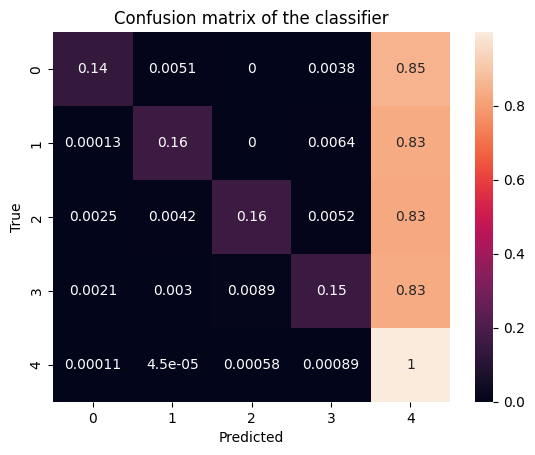

: 

In [18]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [13]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)